# start

In [1]:
TGT='Reply'
PRFX='Reply0521A1'

trntmstmp=1584412344
tsttmstmp=1590075806

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')

SEED=101

trnsz = int(1e4)
valsz = trnsz//10
print(f'train_total {trnsz:,}, valsz {valsz:,}')



import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
train_total 10,000, valsz 1,000
['2020-03-17 02:32:24', '2020-05-21 15:43:26']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(1000, 24)


retwt          0.119
reply          0.029
like           0.449
retwt_cmmnt    0.005
dtype: float64

CPU times: user 48.2 ms, sys: 7.46 ms, total: 55.6 ms
Wall time: 76.9 ms


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(37000, 24)


retwt          0.113730
reply          0.027649
like           0.443054
retwt_cmmnt    0.008703
dtype: float64

CPU times: user 459 ms, sys: 84 ms, total: 543 ms
Wall time: 721 ms


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(10000, 24) 0.1023
37000 1023 10000 1023


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
70,101\t137\t52523\t39084\t39900\t5876\t85041\t40...,NaN,9E21788CC6D760784273C9952B90CEAA,NaN,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581340408,B8CA7C7EBA3572871081402EB7542D85,146,99,False,1499423444,00035DADBBD6B124A973285896F0F17B,59,65,False,1467712721,True,False,True,False,False
150,101\t1910\t11588\t37311\t14120\t131\t120\t120\...,NaN,7D4BC528FFFF7379CAC66718DD6EBBAD,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581114842,01F88F00C8D963AC8747BCF4FE895E08,20857,22920,False,1523701312,0003B21AE5ADBC96763B51DC282052B5,656,726,False,1576464402,True,False,True,True,False
218,101\t36351\t11447\t35562\t25230\t10219\t19613\...,NaN,6C535C189A106A1574A70DB5380A1C5F,Photo,NaN,NaN,TopLevel,4DC22C3F31C5C43721E6B5815A595ED6,1581542376,7D11D77150383AEB9F7CADCD69C19BC6,386283,370,False,1264116386,0003EEEB241410D0A8C2369478C21CC1,1237,1768,False,1314028618,False,False,True,False,False
219,101\t158\t98628\t10213\t10561\t108\t82299\t101...,92C8950848C3E71CB51806C65F7FCC58\t8D14EEDA87DD...,EA16E0F6FF837A1E03C93D78D590845E,Photo,NaN,NaN,TopLevel,4DC22C3F31C5C43721E6B5815A595ED6,1581279317,EBE00D87C4FC4FC037E93FE903E2B647,41218,6149,False,1280798500,0003EEEB241410D0A8C2369478C21CC1,1237,1768,False,1314028618,False,False,True,False,False
262,101\t10294\t10549\t37575\t169\t10250\t10237\t1...,NaN,394552998405BE75BA6A78D162A2CE48,NaN,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1580999312,E25A35C3E3F9DD238EE5D4D3F7E04A49,600,422,False,1556477168,000416B1F5585DEA2B14F6208641F49B,866,445,False,1538329107,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

#     #freq of feature values
#     print(dtnow(), 'freq of columns using CountEncoder')
#     encoder = ce.CountEncoder()
#     encoded = encoder.fit_transform(
#     df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
#        'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
#        'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
#        'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
#     encoded = encoded.astype(int)/lendf
#     encoded.columns = [f'frq_{col}' for col in encoded.columns]
#     df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
#     print(dtnow(), 'freq of tags')
#     for tgnm in tgnms:
#         vs = [j for i in df[f'lst_{tgnm}'] for j in i]
#         cnt = Counter(vs)
#         frq = {k:v/lendf for k,v in cnt.items()}
#         df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
#         df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-05-21 17:45:35 start
2020-05-21 17:45:36 done
CPU times: user 445 ms, sys: 11 ms, total: 456 ms
Wall time: 454 ms


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-05-21 17:45:36 start
2020-05-21 17:45:36 done
CPU times: user 99.5 ms, sys: 7.9 ms, total: 107 ms
Wall time: 108 ms


## tr vl split

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

41

In [12]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [13]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [14]:
cols_feat

['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
 'has_hshtgs',
 'n_hshtgs',
 'has_media',
 'n_media',
 'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour']

In [15]:
print(len(cols_feat))


32


In [16]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat

In [17]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}

results['params'] = params

In [18]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.137868	vl's binary_logloss: 0.305085
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.23256	vl's binary_logloss: 0.290222


tune_feature_fraction, val_score: 0.290222:  14%|#4        | 1/7 [00:48<04:47, 47.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.132463	vl's binary_logloss: 0.306736
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.224783	vl's binary_logloss: 0.290159


tune_feature_fraction, val_score: 0.290159:  29%|##8       | 2/7 [01:04<03:12, 38.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.133348	vl's binary_logloss: 0.304428
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.235047	vl's binary_logloss: 0.289054


tune_feature_fraction, val_score: 0.289054:  43%|####2     | 3/7 [02:09<03:05, 46.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.128318	vl's binary_logloss: 0.306066
Early stopping, best iteration is:
[18]	tr's binary_logloss: 0.241323	vl's binary_logloss: 0.2901


tune_feature_fraction, val_score: 0.289054:  57%|#####7    | 4/7 [02:29<01:55, 38.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.124292	vl's binary_logloss: 0.308309
Early stopping, best iteration is:
[11]	tr's binary_logloss: 0.260681	vl's binary_logloss: 0.290032


tune_feature_fraction, val_score: 0.289054:  71%|#######1  | 5/7 [02:55<01:09, 34.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.122381	vl's binary_logloss: 0.315284
Early stopping, best iteration is:
[12]	tr's binary_logloss: 0.255443	vl's binary_logloss: 0.294387


tune_feature_fraction, val_score: 0.289054:  86%|########5 | 6/7 [03:03<00:26, 26.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.121882	vl's binary_logloss: 0.307173
Early stopping, best iteration is:
[18]	tr's binary_logloss: 0.237466	vl's binary_logloss: 0.292579


tune_num_leaves, val_score: 0.289054:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.00572116	vl's binary_logloss: 0.434752
Early stopping, best iteration is:
[20]	tr's binary_logloss: 0.128925	vl's binary_logloss: 0.29707


tune_num_leaves, val_score: 0.289054:   5%|5         | 1/20 [00:43<13:49, 43.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.0506363	vl's binary_logloss: 0.338448
Early stopping, best iteration is:
[16]	tr's binary_logloss: 0.207495	vl's binary_logloss: 0.295666


tune_num_leaves, val_score: 0.289054:  10%|#         | 2/20 [01:01<10:48, 36.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.0133711	vl's binary_logloss: 0.396507
Early stopping, best iteration is:
[18]	tr's binary_logloss: 0.157172	vl's binary_logloss: 0.297405


tune_num_leaves, val_score: 0.289054:  15%|#5        | 3/20 [01:29<09:30, 33.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.255566	vl's binary_logloss: 0.297379
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.282306	vl's binary_logloss: 0.290997


tune_num_leaves, val_score: 0.289054:  20%|##        | 4/20 [01:34<06:38, 24.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.0588104	vl's binary_logloss: 0.330448
Early stopping, best iteration is:
[17]	tr's binary_logloss: 0.20832	vl's binary_logloss: 0.294891


tune_num_leaves, val_score: 0.289054:  25%|##5       | 5/20 [02:12<07:14, 28.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.0107893	vl's binary_logloss: 0.413123
Early stopping, best iteration is:
[18]	tr's binary_logloss: 0.151157	vl's binary_logloss: 0.299892


tune_num_leaves, val_score: 0.289054:  30%|###       | 6/20 [02:44<06:56, 29.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.0833251	vl's binary_logloss: 0.318242
Early stopping, best iteration is:
[18]	tr's binary_logloss: 0.220777	vl's binary_logloss: 0.289673


tune_num_leaves, val_score: 0.289054:  35%|###5      | 7/20 [03:06<05:57, 27.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.0307317	vl's binary_logloss: 0.351141
Early stopping, best iteration is:
[19]	tr's binary_logloss: 0.178231	vl's binary_logloss: 0.293377


tune_num_leaves, val_score: 0.289054:  40%|####      | 8/20 [03:17<04:29, 22.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.00914087	vl's binary_logloss: 0.425272
Early stopping, best iteration is:
[11]	tr's binary_logloss: 0.192645	vl's binary_logloss: 0.300534


tune_num_leaves, val_score: 0.289054:  45%|####5     | 9/20 [03:44<04:20, 23.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.024525	vl's binary_logloss: 0.358841
Early stopping, best iteration is:
[18]	tr's binary_logloss: 0.175242	vl's binary_logloss: 0.296765


tune_num_leaves, val_score: 0.289054:  50%|#####     | 10/20 [04:22<04:41, 28.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.180957	vl's binary_logloss: 0.29954
Early stopping, best iteration is:
[20]	tr's binary_logloss: 0.259459	vl's binary_logloss: 0.288963


tune_num_leaves, val_score: 0.288963:  55%|#####5    | 11/20 [04:24<03:03, 20.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.204088	vl's binary_logloss: 0.297834
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.26574	vl's binary_logloss: 0.288408


tune_num_leaves, val_score: 0.288408:  60%|######    | 12/20 [04:44<02:40, 20.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.152478	vl's binary_logloss: 0.303339
Early stopping, best iteration is:
[20]	tr's binary_logloss: 0.248099	vl's binary_logloss: 0.289973


tune_num_leaves, val_score: 0.288408:  65%|######5   | 13/20 [05:46<03:49, 32.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273103	vl's binary_logloss: 0.294314
Early stopping, best iteration is:
[42]	tr's binary_logloss: 0.284282	vl's binary_logloss: 0.292952


tune_num_leaves, val_score: 0.288408:  70%|#######   | 14/20 [05:56<02:36, 26.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.123296	vl's binary_logloss: 0.306147
Early stopping, best iteration is:
[19]	tr's binary_logloss: 0.237448	vl's binary_logloss: 0.29043


tune_num_leaves, val_score: 0.288408:  75%|#######5  | 15/20 [06:10<01:50, 22.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273103	vl's binary_logloss: 0.294314
Early stopping, best iteration is:
[42]	tr's binary_logloss: 0.284282	vl's binary_logloss: 0.292952


tune_num_leaves, val_score: 0.288408:  80%|########  | 16/20 [06:11<01:04, 16.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.0060314	vl's binary_logloss: 0.443964
Early stopping, best iteration is:
[15]	tr's binary_logloss: 0.157794	vl's binary_logloss: 0.298281


tune_num_leaves, val_score: 0.288408:  85%|########5 | 17/20 [06:40<00:59, 19.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.11488	vl's binary_logloss: 0.306818
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.226586	vl's binary_logloss: 0.289289


tune_num_leaves, val_score: 0.288408:  90%|######### | 18/20 [06:44<00:30, 15.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.0439029	vl's binary_logloss: 0.333806
Early stopping, best iteration is:
[15]	tr's binary_logloss: 0.206417	vl's binary_logloss: 0.291535


tune_num_leaves, val_score: 0.288408:  95%|#########5| 19/20 [06:52<00:12, 12.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.0176446	vl's binary_logloss: 0.384716
Early stopping, best iteration is:
[11]	tr's binary_logloss: 0.205842	vl's binary_logloss: 0.297563


tune_num_leaves, val_score: 0.288408: 100%|##########| 20/20 [07:04<00:00, 21.22s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.288408:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202147	vl's binary_logloss: 0.295694
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_bagging_fraction_and_bagging_freq, val_score: 0.285443:  10%|#         | 1/10 [00:08<01:12,  8.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.206848	vl's binary_logloss: 0.298059
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.266082	vl's binary_logloss: 0.288064


tune_bagging_fraction_and_bagging_freq, val_score: 0.285443:  20%|##        | 2/10 [00:25<01:27, 10.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.201825	vl's binary_logloss: 0.29729
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265218	vl's binary_logloss: 0.289359


tune_bagging_fraction_and_bagging_freq, val_score: 0.285443:  30%|###       | 3/10 [00:54<01:54, 16.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.203438	vl's binary_logloss: 0.296637
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.261765	vl's binary_logloss: 0.286928


tune_bagging_fraction_and_bagging_freq, val_score: 0.285443:  40%|####      | 4/10 [02:00<03:05, 30.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.203948	vl's binary_logloss: 0.297145
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.264929	vl's binary_logloss: 0.287843


tune_bagging_fraction_and_bagging_freq, val_score: 0.285443:  50%|#####     | 5/10 [02:53<03:07, 37.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.203636	vl's binary_logloss: 0.296603
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.266432	vl's binary_logloss: 0.289741


tune_bagging_fraction_and_bagging_freq, val_score: 0.285443:  60%|######    | 6/10 [03:33<02:34, 38.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.217413	vl's binary_logloss: 0.30675
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.273454	vl's binary_logloss: 0.291966


tune_bagging_fraction_and_bagging_freq, val_score: 0.285443:  70%|#######   | 7/10 [04:34<02:15, 45.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202028	vl's binary_logloss: 0.298745
Early stopping, best iteration is:
[24]	tr's binary_logloss: 0.262972	vl's binary_logloss: 0.286256


tune_bagging_fraction_and_bagging_freq, val_score: 0.285443:  80%|########  | 8/10 [05:19<01:30, 45.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202671	vl's binary_logloss: 0.301517
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.267014	vl's binary_logloss: 0.288598


tune_bagging_fraction_and_bagging_freq, val_score: 0.285443:  90%|######### | 9/10 [05:36<00:36, 36.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.203152	vl's binary_logloss: 0.2966
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265442	vl's binary_logloss: 0.287268


tune_bagging_fraction_and_bagging_freq, val_score: 0.285443: 100%|##########| 10/10 [05:44<00:00, 34.47s/it]
tune_feature_fraction, val_score: 0.285443:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.203838	vl's binary_logloss: 0.293117
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.263322	vl's binary_logloss: 0.28605


tune_feature_fraction, val_score: 0.285443:  17%|#6        | 1/6 [00:07<00:38,  7.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.204989	vl's binary_logloss: 0.295087
Early stopping, best iteration is:
[23]	tr's binary_logloss: 0.265485	vl's binary_logloss: 0.286532


tune_feature_fraction, val_score: 0.285443:  33%|###3      | 2/6 [00:11<00:25,  6.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202147	vl's binary_logloss: 0.295694
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_feature_fraction, val_score: 0.285443:  50%|#####     | 3/6 [00:14<00:16,  5.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.20098	vl's binary_logloss: 0.297366
Early stopping, best iteration is:
[20]	tr's binary_logloss: 0.267406	vl's binary_logloss: 0.288783


tune_feature_fraction, val_score: 0.285443:  67%|######6   | 4/6 [00:17<00:09,  4.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.201489	vl's binary_logloss: 0.298298
Early stopping, best iteration is:
[24]	tr's binary_logloss: 0.26103	vl's binary_logloss: 0.289866


tune_feature_fraction, val_score: 0.285443:  83%|########3 | 5/6 [00:21<00:04,  4.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.200402	vl's binary_logloss: 0.303381
Early stopping, best iteration is:
[19]	tr's binary_logloss: 0.266575	vl's binary_logloss: 0.292777


tune_feature_fraction, val_score: 0.285443: 100%|##########| 6/6 [00:22<00:00,  3.73s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.285443:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.231531	vl's binary_logloss: 0.295459
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.270643	vl's binary_logloss: 0.289186


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:   5%|5         | 1/20 [00:10<03:15, 10.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202954	vl's binary_logloss: 0.297253
Early stopping, best iteration is:
[20]	tr's binary_logloss: 0.268111	vl's binary_logloss: 0.287335


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  10%|#         | 2/20 [00:14<02:32,  8.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202147	vl's binary_logloss: 0.295694
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  15%|#5        | 3/20 [00:20<02:09,  7.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.203654	vl's binary_logloss: 0.295621
Early stopping, best iteration is:
[20]	tr's binary_logloss: 0.267876	vl's binary_logloss: 0.288634


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  20%|##        | 4/20 [00:51<03:52, 14.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202605	vl's binary_logloss: 0.30154
Early stopping, best iteration is:
[20]	tr's binary_logloss: 0.26803	vl's binary_logloss: 0.289057


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  25%|##5       | 5/20 [01:05<03:39, 14.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.219103	vl's binary_logloss: 0.29625
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.268768	vl's binary_logloss: 0.287328


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  30%|###       | 6/20 [01:12<02:51, 12.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202147	vl's binary_logloss: 0.295694
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  35%|###5      | 7/20 [01:27<02:48, 12.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.211394	vl's binary_logloss: 0.295417
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.268914	vl's binary_logloss: 0.287086


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  40%|####      | 8/20 [01:51<03:15, 16.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202147	vl's binary_logloss: 0.295694
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  45%|####5     | 9/20 [02:01<02:40, 14.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.205503	vl's binary_logloss: 0.297831
Early stopping, best iteration is:
[20]	tr's binary_logloss: 0.269129	vl's binary_logloss: 0.287898


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  50%|#####     | 10/20 [02:11<02:11, 13.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202194	vl's binary_logloss: 0.295161
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  55%|#####5    | 11/20 [02:17<01:38, 10.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202147	vl's binary_logloss: 0.295694
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  60%|######    | 12/20 [02:22<01:14,  9.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202147	vl's binary_logloss: 0.295694
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  65%|######5   | 13/20 [02:29<00:59,  8.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202147	vl's binary_logloss: 0.295694
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  70%|#######   | 14/20 [03:09<01:48, 18.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202148	vl's binary_logloss: 0.295694
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  75%|#######5  | 15/20 [03:54<02:10, 26.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202147	vl's binary_logloss: 0.295694
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  80%|########  | 16/20 [04:22<01:46, 26.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.203204	vl's binary_logloss: 0.297609
Early stopping, best iteration is:
[20]	tr's binary_logloss: 0.268106	vl's binary_logloss: 0.287334


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  85%|########5 | 17/20 [04:51<01:21, 27.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202834	vl's binary_logloss: 0.296261
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  90%|######### | 18/20 [05:07<00:47, 23.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202499	vl's binary_logloss: 0.296353
Early stopping, best iteration is:
[18]	tr's binary_logloss: 0.270836	vl's binary_logloss: 0.289103


tune_lambda_l1_and_lambda_l2, val_score: 0.285443:  95%|#########5| 19/20 [05:10<00:17, 17.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.20294	vl's binary_logloss: 0.296346
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.265631	vl's binary_logloss: 0.285443


tune_lambda_l1_and_lambda_l2, val_score: 0.285443: 100%|##########| 20/20 [05:14<00:00, 15.73s/it]
tune_min_child_samples, val_score: 0.285443:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.194805	vl's binary_logloss: 0.295913
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.256353	vl's binary_logloss: 0.289691


tune_min_child_samples, val_score: 0.285443:  20%|##        | 1/5 [00:13<00:52, 13.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.200365	vl's binary_logloss: 0.30125
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.264573	vl's binary_logloss: 0.290706


tune_min_child_samples, val_score: 0.285443:  40%|####      | 2/5 [01:00<01:10, 23.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.203223	vl's binary_logloss: 0.299489
Early stopping, best iteration is:
[20]	tr's binary_logloss: 0.268537	vl's binary_logloss: 0.289004


tune_min_child_samples, val_score: 0.285443:  60%|######    | 3/5 [01:25<00:47, 23.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.209105	vl's binary_logloss: 0.300803
Early stopping, best iteration is:
[23]	tr's binary_logloss: 0.266458	vl's binary_logloss: 0.289205


tune_min_child_samples, val_score: 0.285443:  80%|########  | 4/5 [01:40<00:21, 21.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.213502	vl's binary_logloss: 0.296994
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.269815	vl's binary_logloss: 0.288364


tune_min_child_samples, val_score: 0.285443: 100%|##########| 5/5 [01:56<00:00, 23.22s/it]


CPU times: user 5h 3min 22s, sys: 1h 1min 50s, total: 6h 5min 13s
Wall time: 23min 46s


## best_params

In [19]:
best_params

{'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 13,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.8955325088076977,
 'bagging_freq': 1,
 'min_child_samples': 20}

## tr vl trajec

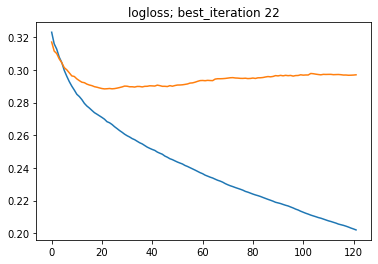

In [20]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

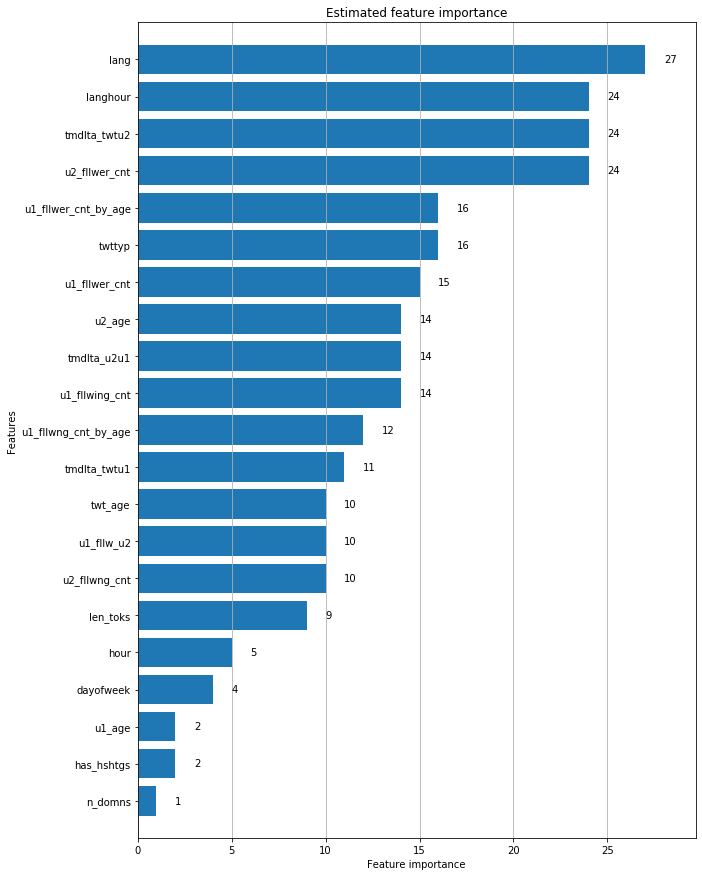

In [21]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [22]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
1,lang,27
31,langhour,24
5,u2_fllwer_cnt,24
25,tmdlta_twtu2,24
29,u1_fllwer_cnt_by_age,16
0,twttyp,16
2,u1_fllwer_cnt,15
28,u2_age,14
3,u1_fllwing_cnt,14
23,tmdlta_u2u1,14


In [23]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('lang', 27),
 ('u2_fllwer_cnt', 24),
 ('tmdlta_twtu2', 24),
 ('langhour', 24),
 ('twttyp', 16),
 ('u1_fllwer_cnt_by_age', 16),
 ('u1_fllwer_cnt', 15),
 ('u1_fllwing_cnt', 14),
 ('tmdlta_u2u1', 14),
 ('u2_age', 14),
 ('u1_fllwng_cnt_by_age', 12),
 ('tmdlta_twtu1', 11),
 ('u2_fllwng_cnt', 10),
 ('u1_fllw_u2', 10),
 ('twt_age', 10),
 ('len_toks', 9),
 ('hour', 5),
 ('dayofweek', 4),
 ('has_hshtgs', 2),
 ('u1_age', 2),
 ('n_domns', 1),
 ('u1_vrfed', 0),
 ('u2_vrfed', 0),
 ('u1inu2', 0),
 ('u2inu1', 0),
 ('n_media_Photo', 0),
 ('n_media_Video', 0),
 ('n_media_GIF', 0),
 ('n_hshtgs', 0),
 ('has_media', 0),
 ('n_media', 0),
 ('has_domns', 0)]

In [24]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['lang',
 'u2_fllwer_cnt',
 'tmdlta_twtu2',
 'langhour',
 'twttyp',
 'u1_fllwer_cnt_by_age',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'tmdlta_u2u1',
 'u2_age',
 'u1_fllwng_cnt_by_age',
 'tmdlta_twtu1',
 'u2_fllwng_cnt',
 'u1_fllw_u2',
 'twt_age',
 'len_toks',
 'hour',
 'dayofweek',
 'has_hshtgs',
 'u1_age',
 'n_domns']

# eval

In [25]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 3.29 s, sys: 636 ms, total: 3.92 s
Wall time: 448 ms


In [26]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 1.32 s, sys: 217 ms, total: 1.54 s
Wall time: 172 ms


In [27]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.4592
auc_vl:  0.2596
auc_val: 0.0676

rce_tr:  19.8424
rce_vl:  11.5484
rce_val: 6.7154


## score

In [28]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.0676-6.7154


# save results

In [29]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [30]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
cols_feat = results['cols_feat']

## prep

In [31]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
#     nrows=10
)

CPU times: user 2min 23s, sys: 12.5 s, total: 2min 35s
Wall time: 2min 38s


In [32]:
dftst.shape

(12434735, 20)

In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-05-21 18:12:04 start
2020-05-21 18:18:55 done
CPU times: user 5min 59s, sys: 43.7 s, total: 6min 43s
Wall time: 6min 52s


In [34]:
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 1min 36s, sys: 26.8 s, total: 2min 3s
Wall time: 1min 8s


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)